
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from statistics import mean
from scipy.stats import tmean
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence

In [3]:
# loading csv
df_original = pd.read_csv('data/FPL_logs.csv')

df = df_original.copy()

In [4]:
# df_original[df_original["Name"] == "Mohamed-Salah"][["xP"]].head(80).tail(40)

In [5]:
df = df.rename(columns={'GW_x': 'GW'})
# df = df[~(df['position'].isin(['GK']))]
# df = df[df['position'].isin(['MID'])]

In [6]:
# df_original[["expected_goals", "xG"]]

In [7]:
# df_original["goals_conceded"].unique()

In [8]:
# df_original.isnull().sum(axis=0).sort_values(ascending=False).head(60)

In [9]:
df_original.columns.to_list()

['Unnamed: 0',
 'Date',
 'Day',
 'Venue',
 'Team',
 'Opponent',
 'Name',
 'Start',
 'Pos',
 'Min',
 'Gls',
 'Ast',
 'PK',
 'PKatt',
 'Sh',
 'SoT',
 'CrdY',
 'CrdR',
 'Touches',
 'Tkl',
 'Int',
 'Blocks',
 'xG',
 'npxG',
 'xA',
 'SCA',
 'GCA',
 'Cmp',
 'Att',
 'Cmp%',
 'PrgP',
 'Carries',
 'PrgC',
 'Att.1',
 'Succ',
 'Season',
 'WDL',
 'Team_score',
 'Opp_score',
 'Team_CS',
 'Was_home',
 'GW',
 'Clean_name',
 'FPL_name',
 'FPL_team',
 'FPL_opp_team',
 'Name_original',
 'FPL_pos',
 'FPL_ast',
 'Bonus',
 'Bps',
 'Player_CS',
 'Creativity',
 'Element',
 'Fixture',
 'Player_GC',
 'Goals_scored',
 'ICT_index',
 'Influence',
 'Kickoff_time',
 'FPL_min',
 'Own_goals',
 'Penalties_missed',
 'Penalties_saved',
 'Saves',
 'Selected',
 'Threat',
 'FPL_points',
 'Transfers_balance',
 'Transfers_in',
 'Transfers_out',
 'Value',
 'FPL_GW',
 'xP',
 'FPL_xA',
 'FPL_xGI',
 'FPL_xG',
 'FPL_xGC',
 'Opp_rating',
 'Team_rating',
 'Min_points']

In [10]:
# df["position"].unique()

In [11]:
df.shape

(24573, 81)

# Features

In [12]:
# rolling_gameweeks = [2, 3, 5, 10, 20, 30]
rolling_gameweeks = [2, 4, 30]

to_predict = ["FPL_points"]
features1 = [
             "Was_home", # Home/Away
             "Team_rating", "Opp_rating", "Rating_difference", # Team ratings
             'Team_tier', 'Opp_tier' # Subjective tier
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xA', # Expected
                'Team_CS', # Defence
                'Team_score', 'Opp_score', 'Team_result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "Succ", "PKwon",
                # 'bonus', 'bps', # Bonus
                # 'influence', 'creativity', 'threat', 'ict_index', # ICT
                "FPL_points", "Baseline_points", "Bonus" # FPL points
            ]
info = ["Name", "GW", "Season", "Team", "Opponent", "Was_home", "Team_rating", "Opp_rating", "Pos"]

In [13]:
# df[features_to_roll + info].isnull().sum(axis=0).sort_values(ascending=False).head(30)

# Preparing dataset

In [14]:
df["Rating_difference"] = df["Team_rating"] / df["Opp_rating"]
# df["Rating Difference2"] = df["Team rating"] > df["Opp rating"]
df["Baseline_points"] = df["FPL_points"] - df["Bonus"]

In [15]:
df["Team"].unique()

array(['West Ham', 'Brentford', 'Arsenal', 'Manchester Utd', 'Everton',
       'Southampton', 'Leeds United', 'Brighton', 'Bournemouth', 'Wolves',
       'Crystal Palace', 'Fulham', 'Aston Villa', 'Liverpool',
       'Newcastle Utd', "Nott'ham Forest", 'Chelsea', 'Tottenham',
       'Manchester City', 'Leicester City', 'Burnley', 'Norwich City',
       'Watford'], dtype=object)

In [16]:
def assign_team_strength(row, team_column):
    tierS = ['Manchester City', 'Arsenal']
    tierA = ['Liverpool', 'Tottenham', 'Manchester Utd', 'Newcastle Utd', 'Chelsea', ]
    tierB = ['Brentford', 'West Ham', 'Everton', 'Brighton', 'Crystal Palace', 'Fulham', 'Aston Villa']
    tierC = ['Southampton', 'Leeds United', 'Bournemouth', 'Wolves', "Nott'ham Forest", 'Leicester City', 'Burnley', 'Watford']
    
    if row[team_column] in tierS:
        return 3
    if row[team_column] in tierA:
        return 2
    if row[team_column] in tierB:
        return 1
    return 0

df['Team_tier'] = df.apply(assign_team_strength, team_column="Team", axis=1)
df['Opp_tier'] = df.apply(assign_team_strength, team_column="Opponent", axis=1)

In [17]:
def calculate_team_points(row):
    if row['Team_score'] > row['Opp_score']:
        return 3
    elif row['Team_score'] == row['Opp_score']:
        return 1
    else:
        return 0
    
df['Team_result'] = df.apply(calculate_team_points, axis=1)

In [18]:
def calculate_xg_points(row):
    if row["Pos"] == "GK":
        return row["xG"] * 6
    elif row["Pos"] == "DEF":
        return row["xG"] * 6
    elif row["Pos"] == "MID":
        return row["xG"] * 5
    elif row["Pos"] == "FWD":
        return row["xG"] * 4
    else:
        return row["xG"] * 5

df["xGPoints"] = df.apply(calculate_xg_points, axis=1)

In [19]:
def calculate_cs_points(row):
    if row["Pos"] == "GK":
        return row["xG"] * 4
    elif row["Pos"] == "DEF":
        return row["xG"] * 4
    elif row["Pos"] == "MID":
        return row["xG"] * 1
    elif row["Pos"] == "FWD":
        return row["xG"] * 0
    else:
        return row["xG"] * 1

df["CSPoints"] = df.apply(calculate_cs_points, axis=1)

In [20]:
def add_rolling_features(df, features1, features_to_roll):
    features = features1
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        form_means = form_means.fillna(method='bfill')
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
    return df, features

In [21]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [22]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [23]:
df = df.reset_index()

In [24]:
df, features = add_rolling_features(df, features1, features_to_roll)

In [25]:
# df, features = ohe(df, ["position"], features)

In [26]:
df = label_encoding(df, "Start")

In [27]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [28]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [29]:
# dropping NaNs
df = df.dropna(axis=0)

In [30]:
df = df.set_index(["Name", "Season", "GW"], drop=False)

In [31]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline_points_2', 'Baseline_points_30',
       'Baseline_points_4', 'Bonus_2', 'Bonus_30', 'Bonus_4', 'CrdR_2',
       'CrdR_30', 'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'FPL_points',
       'FPL_points_2', 'FPL_points_30', 'FPL_points_4', 'GW', 'Gls_2',
       'Gls_30', 'Gls_4', 'Min_2', 'Min_30', 'Min_4', 'Name', 'Opp_rating',
       'Opp_score_2', 'Opp_score_30', 'Opp_score_4', 'Opp_tier', 'Opponent',
       'Pos', 'Rating_difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Team', 'Team_CS_2', 'Team_CS_30', 'Team_CS_4',
       'Team_rating', 'Team_result_2', 'Team_result_30', 'Team_result_4',
       'Team_score_2', 'Team_score_30', 'Team_score_4', 'Team_tier',
       'Was_home', 'xA_2', 'xA_30', 'xA_4', 'xG_2', 'xG_30', 'xG_4'],
      dtype='object')

In [32]:
df.shape

(22131, 61)

# Choosing features and splitting data

In [33]:
GAMEWEEK_TO_PREDICT = 30
SEASON_TO_PREDICT = "2022-23"

In [34]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][to_predict].reset_index(drop=True)

In [35]:
X_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [36]:
X_test_all_remaining = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [37]:
X_train.shape, X_test.shape

((18806, 54), (375, 54))

# Model

In [38]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = []
        for i in range(len(model_preds[0])):
            preds.append(np.mean([x[i] for x in model_preds]))
        return preds
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [39]:
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [
    1,
    1,
    1
]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

model = HybridModel(models, names, weights)

In [40]:
model = GradientBoostingRegressor(random_state=42)
# model = LGBMRegressor(random_state=42)
# model = XGBRegressor(random_state=42)
# model = RandomForestRegressor()

In [41]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 7.19 s
Wall time: 7.19 s


GradientBoostingRegressor(random_state=42)

# Evaluation

In [42]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "Pred"] = predictions
    
    preds = df_predictions[info + to_predict + ["Pred"]].sort_values(by=["Pred"], ascending = False)
    
    return preds, predictions

In [43]:
preds, predictions = get_predictions(model, df, X_test)

In [44]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [45]:
def get_top_performer_names(df, no_top, no_gws):
    return df.reset_index(drop=True).groupby("Name")["FPL_points"].mean().groupby("Name").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [46]:
def pairwise_accuracy_topX(model, df, top_x):
    top_performers = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, top_x, 50)))]
    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

In [47]:
def evaluate(model, df, predictions, y_true):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)

In [48]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [49]:
evaluate(model, df, predictions, y_test)

MAE: 1.7615773191394826
MSE: 6.053075106699289
Pairwise accuracy: 0.5591301247771836
Pairwise accuracy @TOP100: 0.5492997198879552
Pairwise accuracy @TOP20: 0.6274509803921569


In [50]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [51]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

# Valid predictions

In [52]:
preds.head(30)

,Name,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,Pos,FPL_points,Pred
126,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FW,9.0,6.061542
109,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FW,12.0,5.454622
144,Ivan-Toney,30,2022-23,Brentford,Newcastle Utd,1.0,1792.455444,1871.874634,FW,4.0,5.336771
156,James-Maddison,30,2022-23,Leicester City,Bournemouth,1.0,1736.191162,1656.900146,AM,2.0,4.721587
265,Mohamed-Salah,30,2022-23,Liverpool,Arsenal,1.0,1929.042725,1956.794434,RW,5.0,4.616008
249,Martinelli,30,2022-23,Arsenal,Liverpool,0.0,1956.794434,1929.042725,"LW,LM",13.0,4.551606
339,Son-Heung-min,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,AM,7.0,4.513656
242,Marcus-Rashford,30,2022-23,Manchester Utd,Everton,1.0,1880.802124,1694.970825,"FW,LW",6.0,4.453465
17,Andreas-Pereira,30,2022-23,Fulham,West Ham,1.0,1722.582764,1745.203857,AM,2.0,4.405477
285,Ollie-Watkins,30,2022-23,Aston Villa,Nott'ham Forest,1.0,1799.512573,1643.347290,FW,7.0,4.388665


In [53]:
preds[preds["Team"] == "Manchester City"].head(20)

,Name,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,Pos,FPL_points,Pred
109,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FW,12.0,5.454622
209,Kevin-De-Bruyne,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,"CM,AM",9.0,4.247295
145,Jack-Grealish,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,LW,12.0,4.139131
316,Rodri,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DM,2.0,3.928527
98,Ederson,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,GK,2.0,3.916328
139,Ilkay-Gundogan,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,"CM,DM",2.0,3.721604
320,Ruben-Dias,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,CB,2.0,3.669356
236,Manuel-Akanji,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,"RB,CB",2.0,3.621268
272,Nathan-Ake,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,LB,2.0,3.582794
187,John-Stones,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DM,0.0,3.454319


In [54]:
# preds[preds["position"] == "FWD"].head(15)
preds_all, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [55]:
preds_all.head(15)

,Name,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,Pos,FPL_points,Pred
1854,Kevin-De-Bruyne,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,CM,3.0,8.988695
1010,Erling-Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FW,2.0,8.281312
1008,Erling-Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FW,14.0,7.851125
1853,Kevin-De-Bruyne,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,RM,19.0,7.792309
1009,Erling-Haaland,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,FW,8.0,7.611118
1852,Kevin-De-Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,CM,8.0,7.080271
1327,Jack-Grealish,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,LW,7.0,6.759871
888,Dwight-McNeil,37,2022-23,Everton,Wolves,0.0,1699.427124,1726.977295,LB,2.0,6.584216
1329,Jack-Grealish,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,LW,1.0,6.581174
1277,Ilkay-Gundogan,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,0,0.0,6.535233


In [56]:
preds_all[preds_all["Name"] == "Mohamed-Salah"].sort_values(by=["GW"])

,Name,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,Pos,FPL_points,Pred
2380,Mohamed-Salah,30,2022-23,Liverpool,Arsenal,1.0,1929.042725,1956.794434,RW,5.0,4.616008
2381,Mohamed-Salah,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,RW,14.0,4.882307
2382,Mohamed-Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1930.005737,1626.679321,RW,7.0,5.693850
2383,Mohamed-Salah,33,2022-23,Liverpool,West Ham,0.0,1931.599731,1774.066772,RW,2.0,4.691111
2384,Mohamed-Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,RW,7.0,6.248100
2385,Mohamed-Salah,35,2022-23,Liverpool,Brentford,1.0,1943.223999,1784.843750,RW,10.0,5.296456
2386,Mohamed-Salah,36,2022-23,Liverpool,Leicester City,0.0,1947.327637,1712.013672,RW,12.0,5.069236
2387,Mohamed-Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,RW,5.0,5.843229
2388,Mohamed-Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,"RW,RM",5.0,5.273561


In [57]:
preds_all[preds_all["Name"] == "Erling-Haaland"].sort_values(by=["GW"])

,Name,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,Pos,FPL_points,Pred
1006,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FW,12.0,5.454622
1007,Erling-Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FW,12.0,5.883863
1013,Erling-Haaland,32,2022-23,Manchester City,Brighton,0.0,2091.929932,1829.306519,FW,5.0,4.139994
1008,Erling-Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FW,14.0,7.851125
1009,Erling-Haaland,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,FW,8.0,7.611118
1010,Erling-Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FW,2.0,8.281312
1011,Erling-Haaland,36,2022-23,Manchester City,Everton,0.0,2074.110596,1697.794434,FW,7.0,5.602545
1012,Erling-Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FW,1.0,6.336507
1014,Erling-Haaland,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,0,0.0,5.505533


In [58]:
preds_all[preds_all["Name"] == "Harry-Kane"].sort_values(by=["GW"])

,Name,GW,Season,Team,Opponent,Was_home,Team_rating,Opp_rating,Pos,FPL_points,Pred
1179,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FW,9.0,6.061542
1180,Harry-Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FW,2.0,6.451170
1181,Harry-Kane,32,2022-23,Tottenham,Newcastle Utd,0.0,1834.483765,1857.315674,FW,6.0,5.225121
1182,Harry-Kane,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FW,11.0,5.923490
1183,Harry-Kane,34,2022-23,Tottenham,Liverpool,0.0,1820.079712,1936.814331,"FW,AM",8.0,4.793553
1184,Harry-Kane,35,2022-23,Tottenham,Crystal Palace,1.0,1816.056030,1752.288574,FW,8.0,6.106323
1185,Harry-Kane,36,2022-23,Tottenham,Aston Villa,0.0,1822.077881,1803.241211,FW,7.0,5.120249
1186,Harry-Kane,37,2022-23,Tottenham,Brentford,1.0,1819.507935,1796.138916,FW,7.0,5.333681
1187,Harry-Kane,38,2022-23,Tottenham,Leeds United,0.0,1805.765259,1667.934448,FW,16.0,5.606271


# Feature importance and influence

In [59]:
# plot_importance(model)

In [60]:
# fig, ax = plt.subplots(figsize=(16, 8))
# plot_partial_dependence(model, X_train, features, ax=ax)

In [61]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 376it [00:28,  9.33it/s]                                                                                                                                    


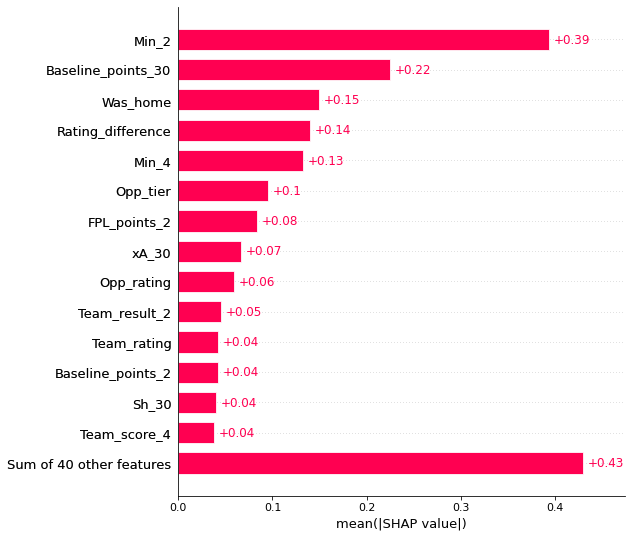

In [62]:
shap.plots.bar(shap_values, max_display=15)

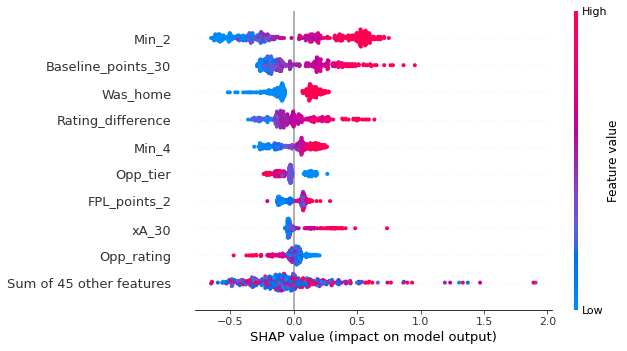

In [63]:
shap.plots.beeswarm(shap_values)

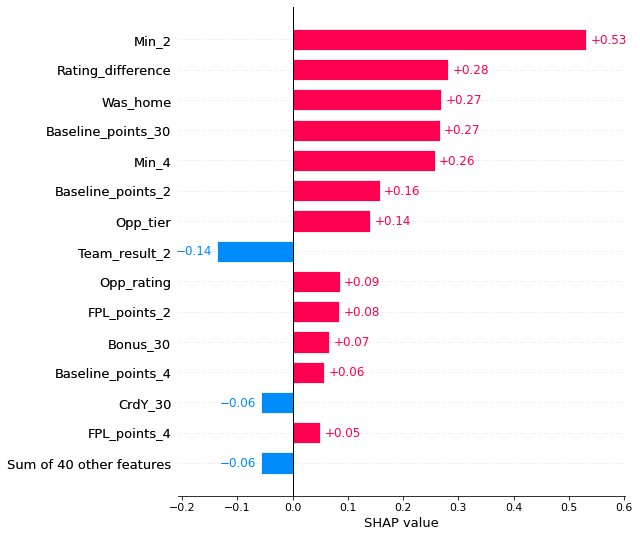

In [64]:
shap.plots.bar(shap_values[105], max_display=15)